In [1]:
import os
import cv2
import time
import gdown
import random
import numpy as np
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [2]:
SEED_CONSTANT = 42
np.random.seed(SEED_CONSTANT)
random.seed(SEED_CONSTANT)
tf.random.set_seed(SEED_CONSTANT)

In [3]:
DATASET = 'all-videos'
DATASET_ZIP = DATASET + '.zip'

if not os.path.exists(f'./{DATASET}') and not os.path.exists(f'./{DATASET_ZIP}'):
    download_link = 'https://drive.google.com/u/0/uc?id=1ptEVU0cZgkRT6l3wKz9iPmgnxMlZnCCY&export=download'
    gdown.download(download_link, DATASET_ZIP, quiet=False)

if not os.path.exists(f'./{DATASET}'):
    !unzip $DATASET_ZIP

Downloading...
From: https://drive.google.com/u/0/uc?id=1ptEVU0cZgkRT6l3wKz9iPmgnxMlZnCCY&export=download
To: /content/all-videos.zip
100%|██████████| 60.0M/60.0M [00:00<00:00, 123MB/s]


Archive:  all-videos.zip
   creating: all-videos/ArmFlapping/
  inflating: all-videos/ArmFlapping/ArmFlapping_1.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_10.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_11.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_12.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_13.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_14.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_15.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_16.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_17.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_18.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_19.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_2.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_20.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_21.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_22.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_23.mp4  
  inflating: all-videos/ArmF

In [4]:
IMAGE_HEIGHT , IMAGE_WIDTH = 128, 128

SEQUENCE_LENGTH = 60

CLASSES_LIST = ["ArmFlapping", "HeadBanging", "Spinning"]

In [5]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255

        frames_list.append(normalized_frame)

    video_reader.release()

    return frames_list

In [6]:
def flip_video(frames):
    flipped_frames = []

    for frame in frames:
        flipped_frame = cv2.flip(frame, 1)  # Flip horizontally
        flipped_frames.append(flipped_frame)

    flipped_frames_array = np.array(flipped_frames)

    return flipped_frames_array

In [7]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET, class_name))

        for file_name in files_list:
            video_file_path = os.path.join(DATASET, class_name, file_name)

            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

                # Apply data augmentation to the frames and include augmented frames
                augmented_frames = flip_video(frames)
                features.append(augmented_frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [8]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: ArmFlapping
Extracting Data of Class: HeadBanging
Extracting Data of Class: Spinning


In [9]:
one_hot_encoded_labels = to_categorical(labels)

In [10]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features, one_hot_encoded_labels, test_size = 0.25,
    shuffle = True, random_state = SEED_CONSTANT
)

In [11]:
def create_lrcn_model():
    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    model.summary()

    return model

In [12]:
lrcn_model = create_lrcn_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 60, 128, 128, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 60, 32, 32, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 60, 32, 32, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 60, 32, 32, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 60, 8, 8, 32)     0

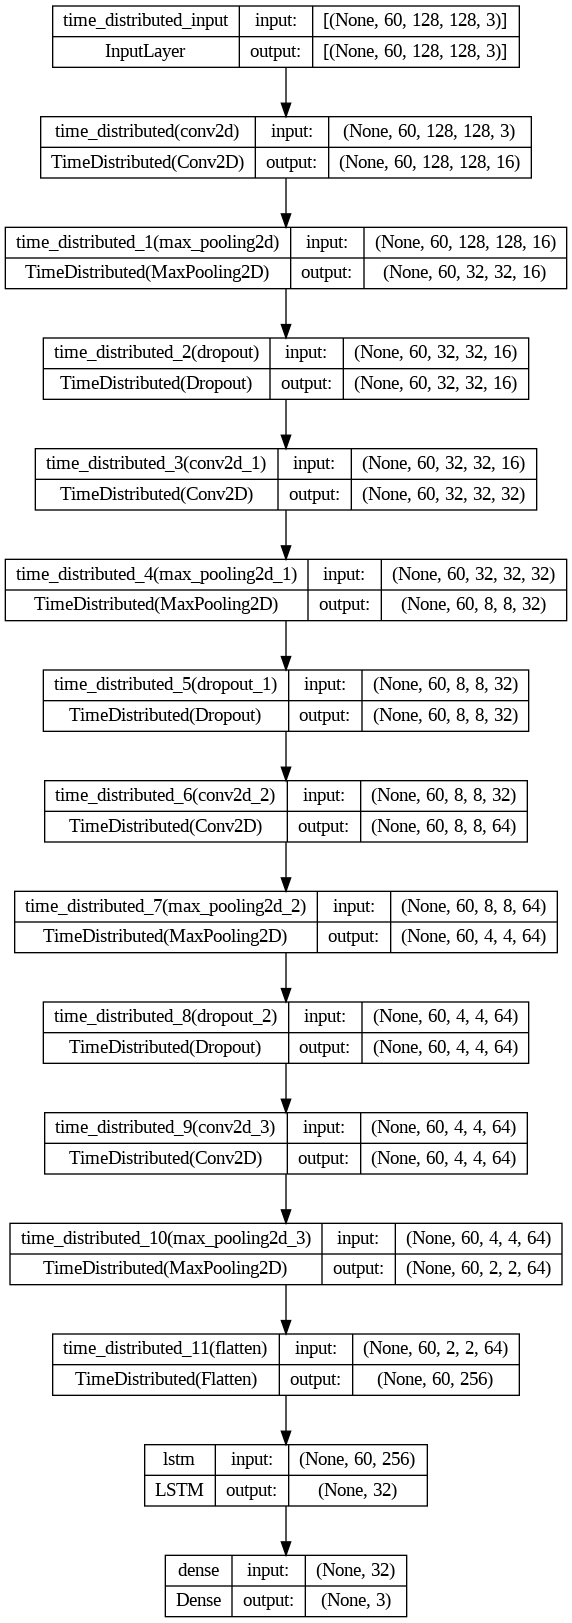

In [13]:
plot_model(
    lrcn_model, to_file = 'lrcn_model_structure_plot.png',
    show_shapes = True, show_layer_names = True
)

In [14]:
early_stopping_callback = EarlyStopping(
    monitor = 'val_loss', patience = 10,
    mode = 'min', restore_best_weights = True
)

lrcn_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'Adam',
    metrics = ["accuracy"]
)

training_start_time = time.time()

lrcn_model_training_history = lrcn_model.fit(
    x = features_train, y = labels_train, epochs = 20,
    batch_size = 4,shuffle = True, validation_split = 0.3,
    callbacks = [early_stopping_callback]
)

training_end_time = time.time()
total_training_time = training_end_time - training_start_time
print(f"Total training time: {total_training_time} seconds")

Epoch 1/20
8/8 [==============================] - 33s 4s/step - loss: 1.1190 - accuracy: 0.5484 - val_loss: 1.0152 - val_accuracy: 0.5714
Epoch 2/20
8/8 [==============================] - 27s 3s/step - loss: 0.9946 - accuracy: 0.5484 - val_loss: 1.0043 - val_accuracy: 0.5714
Epoch 3/20
8/8 [==============================] - 25s 3s/step - loss: 0.9594 - accuracy: 0.5484 - val_loss: 0.9403 - val_accuracy: 0.5714
Epoch 4/20
8/8 [==============================] - 25s 3s/step - loss: 0.9508 - accuracy: 0.5484 - val_loss: 0.9335 - val_accuracy: 0.5714
Epoch 5/20
8/8 [==============================] - 23s 3s/step - loss: 0.9199 - accuracy: 0.5484 - val_loss: 0.9207 - val_accuracy: 0.5714
Epoch 6/20
8/8 [==============================] - 27s 3s/step - loss: 0.8859 - accuracy: 0.5484 - val_loss: 0.8846 - val_accuracy: 0.5714
Epoch 7/20
8/8 [==============================] - 26s 3s/step - loss: 0.8454 - accuracy: 0.5484 - val_loss: 0.8895 - val_accuracy: 0.6429
Epoch 8/20
8/8 [==================

In [15]:
model_evaluation_history = lrcn_model.evaluate(features_test, labels_test)

1/1 [==============================] - 4s 4s/step - loss: 0.7616 - accuracy: 0.7333


In [16]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

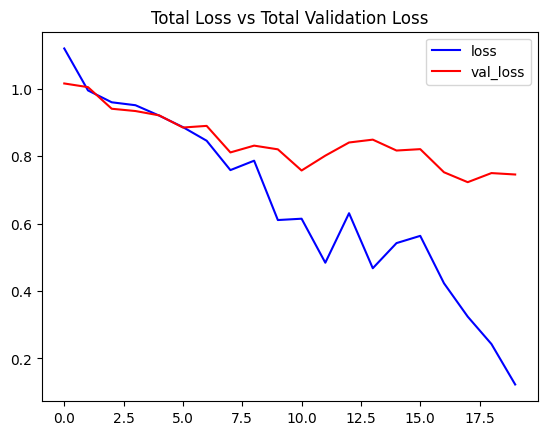

In [17]:
# Visualize the training and validation loss metrices.
plot_metric(lrcn_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

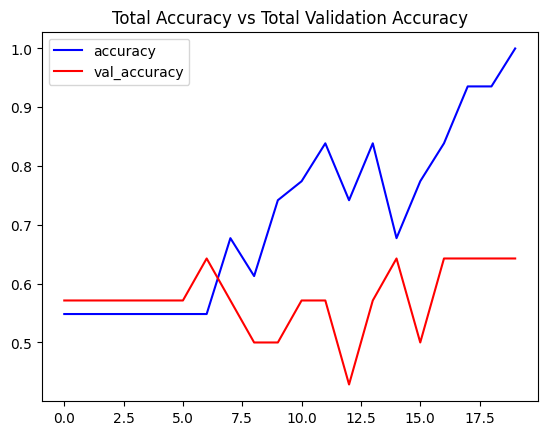

In [18]:
plot_metric(lrcn_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [19]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'lrcn_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

lrcn_model.save(model_file_name)